# Import supporting package

In [1]:
import copy
import glob
from datetime import datetime

# The package for data structure
import xarray as xr
import pandas as pd
import numpy as np

# The packages for working with uncertainties
from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

# The package for plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 # Set the global font size

# -------------- The modules written by us --------------

# The packages for read data
from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file

# The packages for data analysis
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

# Add errorbar plot to xarray package
from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

C:\Users\data\AppData\Roaming\Python\Python39\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57804 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:57807' processes=6 threads=60, memory=55.88 GiB>

# Load Data

## With Modulation

In [3]:
filePath = r'F:\Jianshun\AccordionLatticeShorTermStability\20230808\withModulation.csv'

data = read_csv_file(filePath, csvEngine='pandas', csvKwargs=dict(header=[0], skiprows=[1], encoding = "ISO-8859-1",))
dataWithModulation = xr.DataArray(
    data=data.CH1[0,:],
    dims=['x'],
    coords=dict(
        x=data.X[0,:].to_numpy() * 2e-6
    )
)
dataWithModulation

<xarray.DataArray 'CH1' (x: 6000000)>
array([0.329, 0.317, 0.309, ..., 0.293, 0.305, 0.309])
Coordinates:
  * x        (x) float64 0.0 2e-06 4e-06 6e-06 8e-06 ... 12.0 12.0 12.0 12.0

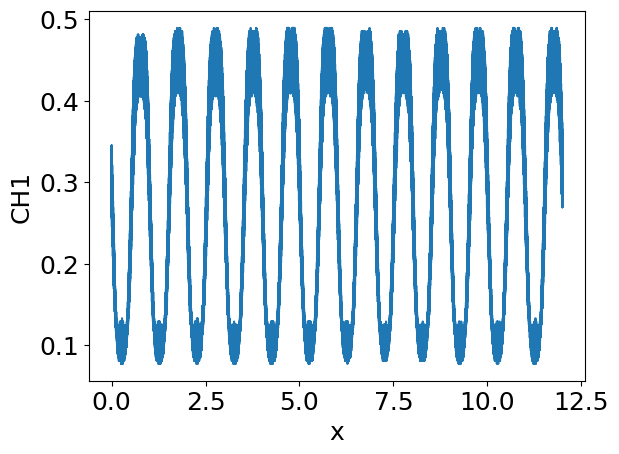

In [4]:
dataWithModulation.plot.errorbar()
plt.show()

In [5]:
dataWithModulation = dataWithModulation - dataWithModulation.mean()

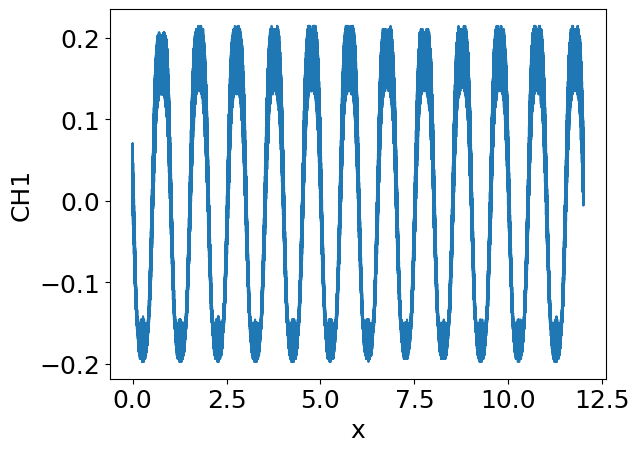

In [6]:
fig = plt.figure()
ax = fig.gca()

dataWithModulation.plot.errorbar(ax=ax)
# ax.set_xlim([0.5, 1])
# ax.set_ylim([0, 0.25])
plt.show()

In [7]:
dataWithModulationFFT = fft(dataWithModulation)

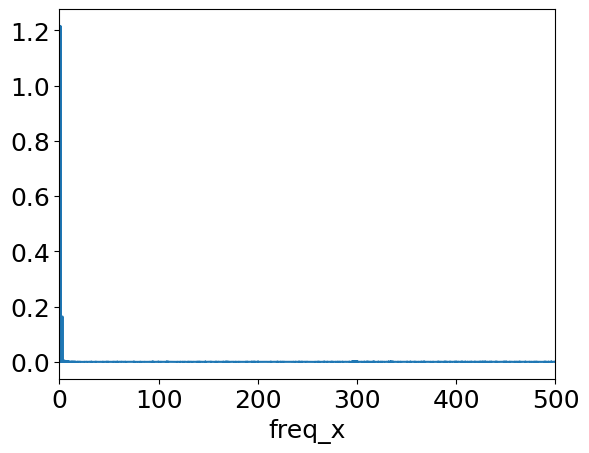

In [8]:
fig = plt.figure()
ax = fig.gca()

abs(dataWithModulationFFT).plot.errorbar(ax=ax, x='freq_x')
ax.set_xlim([0, 500])
# ax.set_ylim([0, 0.25])
plt.show()

## Without Modulation

In [9]:
filePath = r'F:\Jianshun\AccordionLatticeShorTermStability\20230808\withoutModulation.csv'

data = read_csv_file(filePath, csvEngine='pandas', csvKwargs=dict(header=[0], skiprows=[1], encoding = "ISO-8859-1",))
dataWithoutModulation = xr.DataArray(
    data=data.CH1[0,:],
    dims=['x'],
    coords=dict(
        x=data.X[0,:].to_numpy() * 2e-6
    )
)
dataWithoutModulation

<xarray.DataArray 'CH1' (x: 6000000)>
array([0.501, 0.485, 0.473, ..., 0.501, 0.485, 0.477])
Coordinates:
  * x        (x) float64 0.0 2e-06 4e-06 6e-06 8e-06 ... 12.0 12.0 12.0 12.0

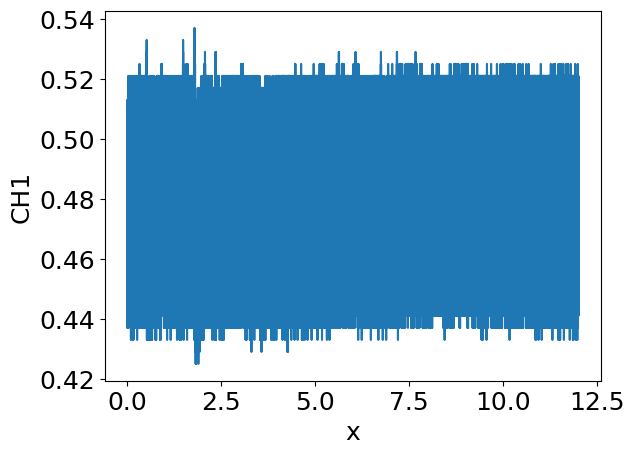

In [10]:
dataWithoutModulation.plot.errorbar()
plt.show()

In [11]:
dataWithoutModulation = dataWithoutModulation - dataWithoutModulation.mean()

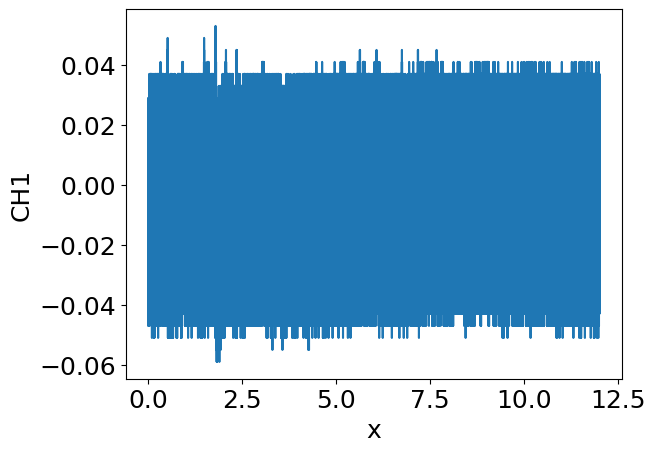

In [12]:
fig = plt.figure()
ax = fig.gca()

dataWithoutModulation.plot.errorbar(ax=ax)
# ax.set_xlim([0.5, 1])
# ax.set_ylim([0, 0.25])
plt.show()

In [13]:
dataWithoutModulationFFT = fft(dataWithoutModulation)

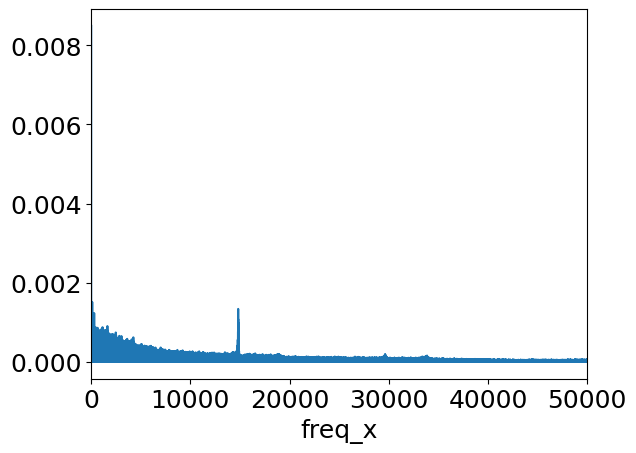

In [35]:
fig = plt.figure()
ax = fig.gca()

abs(dataWithoutModulationFFT).plot.errorbar(ax=ax, x='freq_x')
ax.set_xlim([0, 50e3])
# ax.set_ylim([0, 0.25])
plt.show()

# Data analyse

## Transform intensity to phase

In [15]:
from Analyser.FitAnalyser import NewFitModel

In [16]:
def sine_with_offset(x, amplitude=1.0, frequency=1.0, shift=0.0, offset=0.0):
    """Return a sinusoidal function.

    sine(x, amplitude, frequency, shift) =
        amplitude * sin(x*frequency + shift)

    """
    return amplitude*np.sin(x*frequency + shift) + offset

In [17]:
fitModel = NewFitModel(sine_with_offset)
fitAnalyser = FitAnalyser(fitModel, fitDim=1)

In [36]:
params = fitAnalyser.fitModel.make_params()
params.add(name="amplitude", value=  0.2, max=np.inf, min=0, vary=True)
params.add(name="frequency", value=  1*2*np.pi, max=np.inf, min=0, vary=True)
params.add(name="shift", value=  np.pi/2, max=2*np.pi, min=0, vary=True)
params.add(name="offset", value=  0, max=np.inf, min=-np.inf, vary=True)

In [45]:
# param = fitAnalyser.guess(dataWithModulation)
fitResult = fitAnalyser.fit(
    dataWithModulation.where(-0.1<dataWithModulation).where(dataWithModulation<0.1), 
    params
)
fitCurve = fitAnalyser.eval(fitResult, x=dataWithModulation.x)

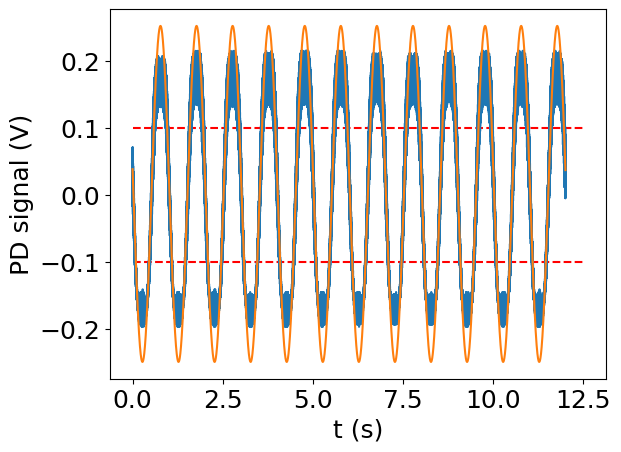

In [64]:
fig = plt.figure()
ax = fig.gca()
dataWithModulation.plot.errorbar(ax=ax)
fitCurve.plot.errorbar(ax=ax)
ax.plot([0, 12.5], [0.1, 0.1], 'r--')
ax.plot([0, 12.5], [-0.1, -0.1], 'r--')
plt.xlabel('t (s)')
plt.ylabel('PD signal (V)')
plt.show()

In [39]:
val = fitAnalyser.get_fit_value(fitResult)
val

<xarray.Dataset>
Dimensions:    ()
Data variables:
    amplitude  float64 0.2026
    frequency  float64 6.283
    shift      float64 3.003
    offset     float64 2.599e-06

In [47]:
def voltage_to_phase(voltage):
    # voltage = (voltage - val.offset)
    # voltage = voltage / val.amplitude
    voltage_frac, b= np.modf(voltage.to_numpy())
    voltage = xr.where(np.abs(voltage) > 1, np.arcsin(voltage_frac) + np.trunc(voltage) * np.pi, np.arcsin(voltage))
    voltage = np.arcsin(voltage)
    return voltage

In [48]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

In [49]:
def get_noise_spectrum(data):
    data = data - data.mean()
    dataAutoCorr = autocorr(data)
    dataAutoCorr = xr.DataArray(
        data=dataAutoCorr,
        dims=['x'],
        coords=dict(
            x=data.x
        )
    )
    
    dataNoiseSpec = fft(dataAutoCorr)
    
    return dataNoiseSpec
    

In [50]:
phaseWithoutModulation = voltage_to_phase(dataWithoutModulation)

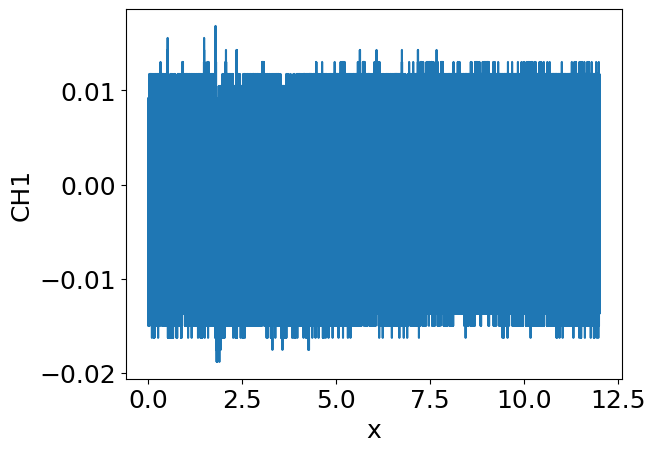

In [68]:
fig = plt.figure()
ax = fig.gca()

(phaseWithoutModulation/np.pi).plot.errorbar(ax=ax)
plt.show()

In [53]:
noiseWithoutModulation = get_noise_spectrum(phaseWithoutModulation)

In [55]:
noiseWithoutModulation

<xarray.DataArray (freq_x: 6000000)>
array([0.00146663-2.99062180e-13j, 0.00146904+2.91230736e-06j,
       0.00146276+5.40701190e-06j, ..., 0.00146716+7.80786951e-06j,
       0.00146276-5.40701190e-06j, 0.00146904-2.91230736e-06j])
Coordinates:
  * freq_x   (freq_x) float64 -2.5e+05 -2.5e+05 -2.5e+05 ... 2.5e+05 2.5e+05

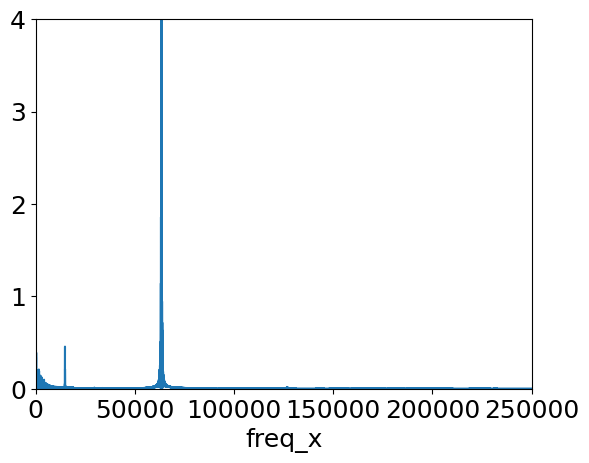

In [70]:
fig = plt.figure()
ax = fig.gca()

abs(noiseWithoutModulation).plot.errorbar(ax=ax)

# plt.xlim([25, 100e3])
plt.xlim([0, 250e3])
plt.ylim([0, 4])
plt.show()

In [28]:
dt = 2e-6
samplingFreq = 1/ dt
blockLength = 6e6
df = samplingFreq / blockLength
print(samplingFreq / 2 / 1e3)
print(df)

250.0
0.08333333333333333


In [73]:
print(list(range(5, -1 ,-1)))

[5, 4, 3, 2, 1, 0]
